In [2]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from transformers import T5Tokenizer, T5EncoderModel
from sklearn.model_selection import train_test_split
from pathlib import Path
import numpy as np

# "Rostlab/prot_t5_xl_half_uniref50-enc" (~1.2B params)
# "Rostlab/prot_t5_base_mt_uniref50" (~220M params) 
MODEL_NAME = "Rostlab/prot_t5_xl_half_uniref50-enc"

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.001
NUM_FOLDS = 3

notebook_dir = Path.cwd()
BASE_DIR = notebook_dir.parent

DATA_PATH = BASE_DIR / "data" / "aufgabe3"
DATA_PATH_FOLDS = DATA_PATH / "3-fold"
MODEL_SAVE_PATH_TEMP = str(BASE_DIR / "models" / "6state_t5_lstm_cnn_fold{}.pt")
MODEL_SAVE_PATH = BASE_DIR / "models" / "6state_t5_lstm_cnn" / "6state_t5_lstm_cnn.pt"
TRAIN_VAL_LOSSES_DATA_SAVE_PATH = DATA_PATH / "6state_t5_lstm_cnn" / "outputs"
TEST_CSV = DATA_PATH / "reduced_30_signalP6_test.csv"

(BASE_DIR / "models" / "6state_t5_lstm_cnn").mkdir(parents=True, exist_ok=True)
(DATA_PATH / "6state_t5_lstm_cnn" / "outputs").mkdir(parents=True, exist_ok=True)
print(f"Project base directory set to: {BASE_DIR}")
print(f"Data path set to: {DATA_PATH}")
print(f"Model save path set to: {MODEL_SAVE_PATH}")
print(f"Using model: {MODEL_NAME}")

/home/jonas/Documents/Projects/sp-prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Project base directory set to: /home/jonas/Documents/Projects/sp-prediction
Data path set to: /home/jonas/Documents/Projects/sp-prediction/data/aufgabe3
Model save path set to: /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn/6state_t5_lstm_cnn.pt
Using model: Rostlab/prot_t5_xl_half_uniref50-enc


In [3]:

print("Loading test data...")
test_df = pd.read_csv(TEST_CSV)
print(f"Test records: {len(test_df)}")

test_df.head()


Loading test data...
Test records: 3419


,uniprot_id,kingdom,type,sequence,labels,length,has_sp
0,B2VGX7,NEGATIVE,TAT,MKAVNPLTENDVTPESLFNARRRTVLKMLGMSAAALSLPGAARADL...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOO...,70,True
1,Q9DEN4,EUKARYA,NO_SP,MTLSGSGSASDMSGQTVLSADDADIDVVGEGDEALDKDSECESTAG...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
2,A9QM74,EUKARYA,NO_SP,MPTLDAPEERRRKFKYRGKDVSLRRQQRMAVSLELRKAKKDEQTLK...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
3,Q8K3I4,EUKARYA,NO_SP,MGRKLDLSGLTDDETEHVLQVVQRDFNLRKKEEDRLSEMKQRLAEE...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
4,Q920M2,EUKARYA,NO_SP,MEVPELGPGLVERLEQLATCPLCGGPFEDPVLLACEHSFCRSCLAR...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False


In [4]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

print("\nProcessing test data...")
test_df_filtered = test_df[~test_df["labels"].str.contains("P", na=False)]
print(f"Test records after filtering: {len(test_df_filtered)}")

test_df_filtered.describe()

test_df_encoded = test_df_filtered.copy()
test_df_encoded["label"] = test_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
test_df_encoded = test_df_encoded[test_df_encoded["label"].map(len) > 0]
test_seqs = test_df_encoded["sequence"].tolist()
test_label_seqs = test_df_encoded["label"].tolist()

print(f"Test sequences: {len(test_seqs)}")
test_df_encoded.describe()



Processing test data...
Test records after filtering: 3412
Test sequences: 3412


,length
count,3412.0
mean,70.0
std,0.0
min,70.0
25%,70.0
50%,70.0
75%,70.0
max,70.0


In [5]:

class SPDatasetWithEmbeddings(Dataset):
    def __init__(self, csv_path, embeddings_path, label_map):
        self.label_map = label_map
        self.df = pd.read_csv(csv_path)
        
        # Filter out sequences with 'P' in labels
        self.df = self.df[~self.df["labels"].str.contains("P", na=False)]
        self.df["label"] = self.df["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
        self.df = self.df[self.df["label"].map(len) > 0]
        
        # Load pre-computed embeddings (keyed by uniprot_id)
        self.embeddings = np.load(embeddings_path)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        uniprot_id = row['uniprot_id']
        labels = row['label']
        
        # Get embedding (seq_len, 1024)
        embedding = torch.tensor(self.embeddings[uniprot_id], dtype=torch.float32)
        seq_len = embedding.shape[0]
        
        # Create labels tensor
        token_labels = list(labels) + [-100]  # -100 for EOS
        while len(token_labels) < seq_len + 1:
            token_labels.append(-100)
        token_labels = token_labels[:seq_len]
        
        # Attention mask (all 1s for actual sequence)
        attention_mask = torch.ones(seq_len, dtype=torch.long)
        
        return {
            'embeddings': embedding,           # (seq_len, 1024)
            'attention_mask': attention_mask,  # (seq_len,)
            'labels': torch.tensor(token_labels)
        }

# Test dataset
# test_dataset = SPDatasetWithEmbeddings(TEST_CSV, DATA_PATH / "6state_t5_lstm_cnn" / "outputs" / "test_embeddings.npz", label_map)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print(f"\nTest data prepared: {len(test_dataset)} sequences")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class SPCNNClassifier(nn.Module):
    def __init__(self, embedding_dim=1024, num_labels=6):
        super().__init__()
        self.dropout = nn.Dropout(0.35)
        
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=1024, kernel_size=5, padding=2)
        self.bn_conv = nn.BatchNorm1d(1024)
        
        self.lstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, 
                           bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(512 * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, embeddings, attention_mask, labels=None):
        # embeddings: (seq_len, 1024)
        hidden_states = embeddings.float()
        
        # Apply conv, batch normalization and ReLU
        x_conv = self.conv(hidden_states.transpose(1, 2))
        x_conv = self.bn_conv(x_conv)
        x_conv = F.relu_(x_conv)
        
        # Transpose for LSTM
        x_lstm_input = x_conv.transpose(1, 2)
        
        # Apply LSTM
        lstm_out, _ = self.lstm(x_lstm_input)
        
        # Classifier
        x_linear = self.classifier(lstm_out)
        logits = self.dropout(x_linear)
        
        if labels is not None:
            crf_mask = (attention_mask.bool()) & (labels != -100)
            
            # Replace -100 with 0 for CRF compatibility
            mod_labels = labels.clone()
            mod_labels[labels == -100] = 0
            
            loss = -self.crf(logits, mod_labels, mask=crf_mask, reduction='mean')
            return loss
        else:
            # Decode only valid positions
            crf_mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=crf_mask)
            return predictions

In [7]:
def prepare_fold_data_with_embeddings(fold_num):
    train_csv = DATA_PATH_FOLDS / f"fold_{fold_num}_train.csv"
    val_csv = DATA_PATH_FOLDS / f"fold_{fold_num}_val.csv"
    train_emb = DATA_PATH_FOLDS / f"fold_{fold_num}_train_embeddings.npz"
    val_emb = DATA_PATH_FOLDS / f"fold_{fold_num}_val_embeddings.npz"
    
    train_dataset = SPDatasetWithEmbeddings(train_csv, train_emb, label_map)
    val_dataset = SPDatasetWithEmbeddings(val_csv, val_emb, label_map)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, val_loader


In [8]:
# sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # reconstruct the sequences from the flat predictions
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # check if the valid predictions match the labels
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


In [9]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import gc
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

# Store results for all folds
fold_results = {
    'train_losses': [],
    'val_losses': [],
    'best_val_losses': [],
    'fold_numbers': [],
    # New validation metrics
    'val_token_acc': [],
    'val_seq_acc': [],
    'val_mcc': [],
    'val_precision': [],
    'val_recall': [],
    'best_metrics': []  # Store best epoch metrics for each fold
}

# Cross Validation Training Loop
for fold in range(1, NUM_FOLDS + 1):
    print(f"\n{'='*60}")
    print(f"Starting Fold {fold}/{NUM_FOLDS}")
    print(f"{'='*60}")

    # Prepare data for this fold
    train_loader, val_loader = prepare_fold_data_with_embeddings(fold)

    # Get validation label sequences for sequence-level accuracy
    val_csv = os.path.join(DATA_PATH_FOLDS, f"fold_{fold}_val.csv")
    val_df = pd.read_csv(val_csv)
    val_df_filtered = val_df[~val_df["labels"].str.contains("P", na=False)]
    val_df_encoded = val_df_filtered.copy()
    val_df_encoded["label"] = val_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
    val_df_encoded = val_df_encoded[val_df_encoded["label"].map(len) > 0]
    val_label_seqs = val_df_encoded["label"].tolist()

    # new model for each fold
    model = SPCNNClassifier(embedding_dim=1024, num_labels=NUM_CLASSES).to(DEVICE)

    scaler = GradScaler()

    # Track losses and metrics for this fold
    train_losses = []
    val_losses = []
    val_token_accs = []
    val_seq_accs = []
    val_mccs = []
    val_precisions = []
    val_recalls = []
    
    best_val_loss = float('inf')
    best_mcc = -1.0  # Track best MCC for model selection
    best_metrics = {}
    patience = 4
    patience_counter = 0

    # Training loop for this fold
    for epoch in range(EPOCHS):
        # Create optimizer
        optimizer = torch.optim.AdamW([
            {"params": model.conv.parameters(), "lr": 1e-3},
            {"params": model.classifier.parameters(), "lr": 1e-3},
            {"params": model.lstm.parameters(), "lr": 1e-3},
            {"params": model.crf.parameters(), "lr": 1e-3},
        ])

        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
        total_train_loss = 0

        for batch in pbar:
            try:
                embeddings = batch['embeddings'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                token_labels = batch['labels'].to(DEVICE)

                optimizer.zero_grad()
                loss = model(embeddings, attention_mask, token_labels)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()

                total_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

            except RuntimeError as e:
                print("Error during training:", e)
                gc.collect()
                continue

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase with metrics
        model.eval()
        total_val_loss = 0
        val_batches = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch"):
                embeddings = batch['embeddings'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                token_labels = batch['labels'].to(DEVICE)

                loss = model(embeddings, attention_mask, token_labels)
                total_val_loss += loss.item()
                val_batches += 1

                # Get predictions for metrics
                predictions = model(embeddings, attention_mask)
                
                # Collect valid tokens (skip -100 labels)
                for pred_seq, label_seq, mask in zip(predictions, token_labels, attention_mask):
                    for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                        if true.item() != -100 and is_valid.item() == 1:
                            all_val_preds.append(pred)
                            all_val_labels.append(true.item())

        avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)

        # Calculate validation metrics
        if len(all_val_preds) > 0:
            token_acc = accuracy_score(all_val_labels, all_val_preds)
            seq_acc = sequence_level_accuracy(all_val_preds, all_val_labels, val_label_seqs)
            mcc = matthews_corrcoef(all_val_labels, all_val_preds)
            precision = precision_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
            recall = recall_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
        else:
            token_acc = seq_acc = mcc = precision = recall = 0.0

        val_token_accs.append(token_acc)
        val_seq_accs.append(seq_acc)
        val_mccs.append(mcc)
        val_precisions.append(precision)
        val_recalls.append(recall)

        print(f"Fold {fold} - Epoch {epoch+1}/{EPOCHS}")
        print(f"  Loss: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}")
        print(f"  Metrics: TokenAcc={token_acc:.4f}, SeqAcc={seq_acc:.4f}, MCC={mcc:.4f}, Prec={precision:.4f}, Rec={recall:.4f}")

        # Save best model for fold based on MCC (not validation loss)
        if mcc > best_mcc:
            patience_counter = 0
            best_mcc = mcc
            best_val_loss = avg_val_loss  # Still track for reference
            best_metrics = {
                'epoch': epoch + 1,
                'val_loss': avg_val_loss,
                'token_acc': token_acc,
                'seq_acc': seq_acc,
                'mcc': mcc,
                'precision': precision,
                'recall': recall
            }
            model_path_temp = MODEL_SAVE_PATH_TEMP.format(fold)
            torch.save(model.state_dict(), model_path_temp)
            print(f"  → Best model for fold {fold} saved to {model_path_temp} (MCC={mcc:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for fold {fold}")
                break

    # Store results for fold
    fold_results['train_losses'].append(train_losses)
    fold_results['val_losses'].append(val_losses)
    fold_results['best_val_losses'].append(best_val_loss)
    fold_results['fold_numbers'].append(fold)
    fold_results['val_token_acc'].append(val_token_accs)
    fold_results['val_seq_acc'].append(val_seq_accs)
    fold_results['val_mcc'].append(val_mccs)
    fold_results['val_precision'].append(val_precisions)
    fold_results['val_recall'].append(val_recalls)
    fold_results['best_metrics'].append(best_metrics)

    print(f"\nFold {fold} Best Metrics (Epoch {best_metrics['epoch']}):")
    print(f"  Val Loss: {best_metrics['val_loss']:.4f}")
    print(f"  Token Acc: {best_metrics['token_acc']:.4f}")
    print(f"  Seq Acc: {best_metrics['seq_acc']:.4f}")
    print(f"  MCC: {best_metrics['mcc']:.4f}")
    print(f"  Precision: {best_metrics['precision']:.4f}")
    print(f"  Recall: {best_metrics['recall']:.4f}")


print("\n" + "="*60)
print("K-Fold Cross Validation Complete!")
print("="*60)

print("\nSummary of all folds:")
for i, (best_loss, best_m) in enumerate(zip(fold_results['best_val_losses'], fold_results['best_metrics']), 1):
    print(f"Fold {i}: Loss={best_loss:.4f}, TokenAcc={best_m['token_acc']:.4f}, SeqAcc={best_m['seq_acc']:.4f}, MCC={best_m['mcc']:.4f}")

avg_best_val_loss = sum(fold_results['best_val_losses']) / NUM_FOLDS
avg_token_acc = sum(m['token_acc'] for m in fold_results['best_metrics']) / NUM_FOLDS
avg_seq_acc = sum(m['seq_acc'] for m in fold_results['best_metrics']) / NUM_FOLDS
avg_mcc = sum(m['mcc'] for m in fold_results['best_metrics']) / NUM_FOLDS
avg_precision = sum(m['precision'] for m in fold_results['best_metrics']) / NUM_FOLDS
avg_recall = sum(m['recall'] for m in fold_results['best_metrics']) / NUM_FOLDS

print(f"\nAverage Best Metrics across all folds:")
print(f"  Val Loss: {avg_best_val_loss:.4f}")
print(f"  Token Acc: {avg_token_acc:.4f}")
print(f"  Seq Acc: {avg_seq_acc:.4f}")
print(f"  MCC: {avg_mcc:.4f}")
print(f"  Precision: {avg_precision:.4f}")
print(f"  Recall: {avg_recall:.4f}")

# Find best fold based on MCC (not validation loss)
best_fold_mccs = [m['mcc'] for m in fold_results['best_metrics']]
best_fold_idx = best_fold_mccs.index(max(best_fold_mccs))
best_fold_num = fold_results['fold_numbers'][best_fold_idx]
best_fold_mcc = best_fold_mccs[best_fold_idx]
best_fold_loss = fold_results['best_val_losses'][best_fold_idx]

print(f"\n{'='*60}")
print(f"Best performing fold: Fold {best_fold_num} (selected by MCC)")
print(f"Best MCC: {best_fold_mcc:.4f}")
print(f"Corresponding validation loss: {best_fold_loss:.4f}")
print(f"{'='*60}")

# best model saved to MODEL_SAVE_PATH
import shutil
best_model_path = MODEL_SAVE_PATH_TEMP.format(best_fold_num)
shutil.copy(best_model_path, MODEL_SAVE_PATH)
print(f"\nBest model (Fold {best_fold_num}) saved to: {MODEL_SAVE_PATH}")

# clean up of temporary fold models
print("\nTemporary fold models:")
for i in range(1, NUM_FOLDS + 1):
    temp_path = MODEL_SAVE_PATH_TEMP.format(i)
    if os.path.exists(temp_path):
        print(f"  - {temp_path}")

os.makedirs(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, exist_ok=True)
losses_pickle_path = os.path.join(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, "6state_t5_lstm_cnn_fold_results.pkl")

losses_data = {
    'fold_numbers': fold_results['fold_numbers'],
    'train_losses': fold_results['train_losses'],
    'val_losses': fold_results['val_losses'],
    'best_val_losses': fold_results['best_val_losses'],
    'val_token_acc': fold_results['val_token_acc'],
    'val_seq_acc': fold_results['val_seq_acc'],
    'val_mcc': fold_results['val_mcc'],
    'val_precision': fold_results['val_precision'],
    'val_recall': fold_results['val_recall'],
    'best_metrics': fold_results['best_metrics'],
    'best_fold_num': best_fold_num,
    'best_fold_mcc': best_fold_mcc,
    'best_fold_loss': best_fold_loss,
    'avg_best_val_loss': avg_best_val_loss,
    'avg_token_acc': avg_token_acc,
    'avg_seq_acc': avg_seq_acc,
    'avg_mcc': avg_mcc,
    'avg_precision': avg_precision,
    'avg_recall': avg_recall,
    'epochs': EPOCHS,
    'num_folds': NUM_FOLDS
}

with open(losses_pickle_path, 'wb') as f:
    pickle.dump(losses_data, f)

print(f"\nTraining results saved to: {losses_pickle_path}")


Starting Fold 1/3


Fold 1 - Epoch 1/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 14.41batch/s]


Fold 1 - Epoch 1/20
  Loss: Train=30.8009, Val=7.9349
  Metrics: TokenAcc=0.9552, SeqAcc=0.8313, MCC=0.8899, Prec=0.9560, Rec=0.9552
  → Best model for fold 1 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold1.pt (MCC=0.8899)


Fold 1 - Epoch 2/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.10batch/s]


Fold 1 - Epoch 2/20
  Loss: Train=18.4333, Val=6.9056
  Metrics: TokenAcc=0.9519, SeqAcc=0.8436, MCC=0.8812, Prec=0.9526, Rec=0.9519


Fold 1 - Epoch 3/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.07batch/s]


Fold 1 - Epoch 3/20
  Loss: Train=11.7783, Val=5.7818
  Metrics: TokenAcc=0.9534, SeqAcc=0.8464, MCC=0.8834, Prec=0.9535, Rec=0.9534


Fold 1 - Epoch 4/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.08batch/s]


Fold 1 - Epoch 4/20
  Loss: Train=7.9183, Val=5.9429
  Metrics: TokenAcc=0.9514, SeqAcc=0.8473, MCC=0.8828, Prec=0.9529, Rec=0.9514


Fold 1 - Epoch 5/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.16batch/s]


Fold 1 - Epoch 5/20
  Loss: Train=5.6388, Val=4.2808
  Metrics: TokenAcc=0.9525, SeqAcc=0.8484, MCC=0.8867, Prec=0.9550, Rec=0.9525
Early stopping at epoch 5 for fold 1

Fold 1 Best Metrics (Epoch 1):
  Val Loss: 7.9349
  Token Acc: 0.9552
  Seq Acc: 0.8313
  MCC: 0.8899
  Precision: 0.9560
  Recall: 0.9552

Starting Fold 2/3


Fold 2 - Epoch 1/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 14.56batch/s]


Fold 2 - Epoch 1/20
  Loss: Train=31.9591, Val=9.3820
  Metrics: TokenAcc=0.9475, SeqAcc=0.8291, MCC=0.8755, Prec=0.9484, Rec=0.9475
  → Best model for fold 2 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold2.pt (MCC=0.8755)


Fold 2 - Epoch 2/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.13batch/s]


Fold 2 - Epoch 2/20
  Loss: Train=18.0647, Val=7.9019
  Metrics: TokenAcc=0.9500, SeqAcc=0.8348, MCC=0.8791, Prec=0.9498, Rec=0.9500
  → Best model for fold 2 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold2.pt (MCC=0.8791)


Fold 2 - Epoch 3/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.29batch/s]


Fold 2 - Epoch 3/20
  Loss: Train=11.5372, Val=7.2637
  Metrics: TokenAcc=0.9490, SeqAcc=0.8377, MCC=0.8764, Prec=0.9491, Rec=0.9490


Fold 2 - Epoch 4/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.20batch/s]


Fold 2 - Epoch 4/20
  Loss: Train=7.9065, Val=6.0180
  Metrics: TokenAcc=0.9496, SeqAcc=0.8364, MCC=0.8821, Prec=0.9516, Rec=0.9496
  → Best model for fold 2 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold2.pt (MCC=0.8821)


Fold 2 - Epoch 5/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.33batch/s]


Fold 2 - Epoch 5/20
  Loss: Train=5.2500, Val=5.1724
  Metrics: TokenAcc=0.9501, SeqAcc=0.8366, MCC=0.8785, Prec=0.9496, Rec=0.9501


Fold 2 - Epoch 6/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.31batch/s]


Fold 2 - Epoch 6/20
  Loss: Train=3.8273, Val=4.7837
  Metrics: TokenAcc=0.9476, SeqAcc=0.8291, MCC=0.8780, Prec=0.9502, Rec=0.9476


Fold 2 - Epoch 7/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.11batch/s]


Fold 2 - Epoch 7/20
  Loss: Train=2.5745, Val=5.7948
  Metrics: TokenAcc=0.9497, SeqAcc=0.8331, MCC=0.8787, Prec=0.9499, Rec=0.9497


Fold 2 - Epoch 8/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.33batch/s]


Fold 2 - Epoch 8/20
  Loss: Train=1.8311, Val=6.7913
  Metrics: TokenAcc=0.9509, SeqAcc=0.8406, MCC=0.8824, Prec=0.9510, Rec=0.9509
  → Best model for fold 2 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold2.pt (MCC=0.8824)


Fold 2 - Epoch 9/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.08batch/s]


Fold 2 - Epoch 9/20
  Loss: Train=1.5107, Val=6.4380
  Metrics: TokenAcc=0.9487, SeqAcc=0.8364, MCC=0.8758, Prec=0.9483, Rec=0.9487


Fold 2 - Epoch 10/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.28batch/s]


Fold 2 - Epoch 10/20
  Loss: Train=1.2404, Val=7.3744
  Metrics: TokenAcc=0.9494, SeqAcc=0.8318, MCC=0.8780, Prec=0.9491, Rec=0.9494


Fold 2 - Epoch 11/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.16batch/s]


Fold 2 - Epoch 11/20
  Loss: Train=1.0045, Val=7.8785
  Metrics: TokenAcc=0.9498, SeqAcc=0.8419, MCC=0.8781, Prec=0.9491, Rec=0.9498


Fold 2 - Epoch 12/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 14.96batch/s]


Fold 2 - Epoch 12/20
  Loss: Train=0.7824, Val=8.0285
  Metrics: TokenAcc=0.9469, SeqAcc=0.8236, MCC=0.8725, Prec=0.9473, Rec=0.9469
Early stopping at epoch 12 for fold 2

Fold 2 Best Metrics (Epoch 8):
  Val Loss: 6.7913
  Token Acc: 0.9509
  Seq Acc: 0.8406
  MCC: 0.8824
  Precision: 0.9510
  Recall: 0.9509

Starting Fold 3/3


Fold 3 - Epoch 1/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 14.37batch/s]


Fold 3 - Epoch 1/20
  Loss: Train=29.5796, Val=9.1481
  Metrics: TokenAcc=0.9476, SeqAcc=0.8488, MCC=0.8766, Prec=0.9531, Rec=0.9476
  → Best model for fold 3 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold3.pt (MCC=0.8766)


Fold 3 - Epoch 2/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 14.77batch/s]


Fold 3 - Epoch 2/20
  Loss: Train=16.9646, Val=6.9580
  Metrics: TokenAcc=0.9533, SeqAcc=0.8518, MCC=0.8838, Prec=0.9533, Rec=0.9533
  → Best model for fold 3 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold3.pt (MCC=0.8838)


Fold 3 - Epoch 3/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.04batch/s]


Fold 3 - Epoch 3/20
  Loss: Train=10.9440, Val=5.8057
  Metrics: TokenAcc=0.9566, SeqAcc=0.8593, MCC=0.8905, Prec=0.9564, Rec=0.9566
  → Best model for fold 3 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold3.pt (MCC=0.8905)


Fold 3 - Epoch 4/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.09batch/s]


Fold 3 - Epoch 4/20
  Loss: Train=7.3823, Val=5.4539
  Metrics: TokenAcc=0.9561, SeqAcc=0.8578, MCC=0.8890, Prec=0.9555, Rec=0.9561


Fold 3 - Epoch 5/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.07batch/s]


Fold 3 - Epoch 5/20
  Loss: Train=4.9835, Val=5.2940
  Metrics: TokenAcc=0.9581, SeqAcc=0.8606, MCC=0.8963, Prec=0.9583, Rec=0.9581
  → Best model for fold 3 saved to /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn_fold3.pt (MCC=0.8963)


Fold 3 - Epoch 6/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.12batch/s]


Fold 3 - Epoch 6/20
  Loss: Train=3.4282, Val=5.9061
  Metrics: TokenAcc=0.9524, SeqAcc=0.8571, MCC=0.8791, Prec=0.9523, Rec=0.9524


Fold 3 - Epoch 7/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.02batch/s]


Fold 3 - Epoch 7/20
  Loss: Train=2.4095, Val=4.2077
  Metrics: TokenAcc=0.9542, SeqAcc=0.8554, MCC=0.8862, Prec=0.9545, Rec=0.9542


Fold 3 - Epoch 8/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.34batch/s]


Fold 3 - Epoch 8/20
  Loss: Train=1.9483, Val=5.3006
  Metrics: TokenAcc=0.9554, SeqAcc=0.8608, MCC=0.8903, Prec=0.9561, Rec=0.9554


Fold 3 - Epoch 9/20 [Val]: 100%|██████████| 143/143 [00:09<00:00, 15.08batch/s]


Fold 3 - Epoch 9/20
  Loss: Train=1.5867, Val=6.5302
  Metrics: TokenAcc=0.9557, SeqAcc=0.8573, MCC=0.8887, Prec=0.9552, Rec=0.9557
Early stopping at epoch 9 for fold 3

Fold 3 Best Metrics (Epoch 5):
  Val Loss: 5.2940
  Token Acc: 0.9581
  Seq Acc: 0.8606
  MCC: 0.8963
  Precision: 0.9583
  Recall: 0.9581

K-Fold Cross Validation Complete!

Summary of all folds:
Fold 1: Loss=7.9349, TokenAcc=0.9552, SeqAcc=0.8313, MCC=0.8899
Fold 2: Loss=6.7913, TokenAcc=0.9509, SeqAcc=0.8406, MCC=0.8824
Fold 3: Loss=5.2940, TokenAcc=0.9581, SeqAcc=0.8606, MCC=0.8963

Average Best Metrics across all folds:
  Val Loss: 6.6734
  Token Acc: 0.9547
  Seq Acc: 0.8442
  MCC: 0.8895
  Precision: 0.9551
  Recall: 0.9547

Best performing fold: Fold 3 (selected by MCC)
Best MCC: 0.8963
Corresponding validation loss: 5.2940

Best model (Fold 3) saved to: /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn/6state_t5_lstm_cnn.pt

Temporary fold models:
  - /home/jonas/Documents/Projects/sp-pred

NameError: name 'fold_results' is not defined

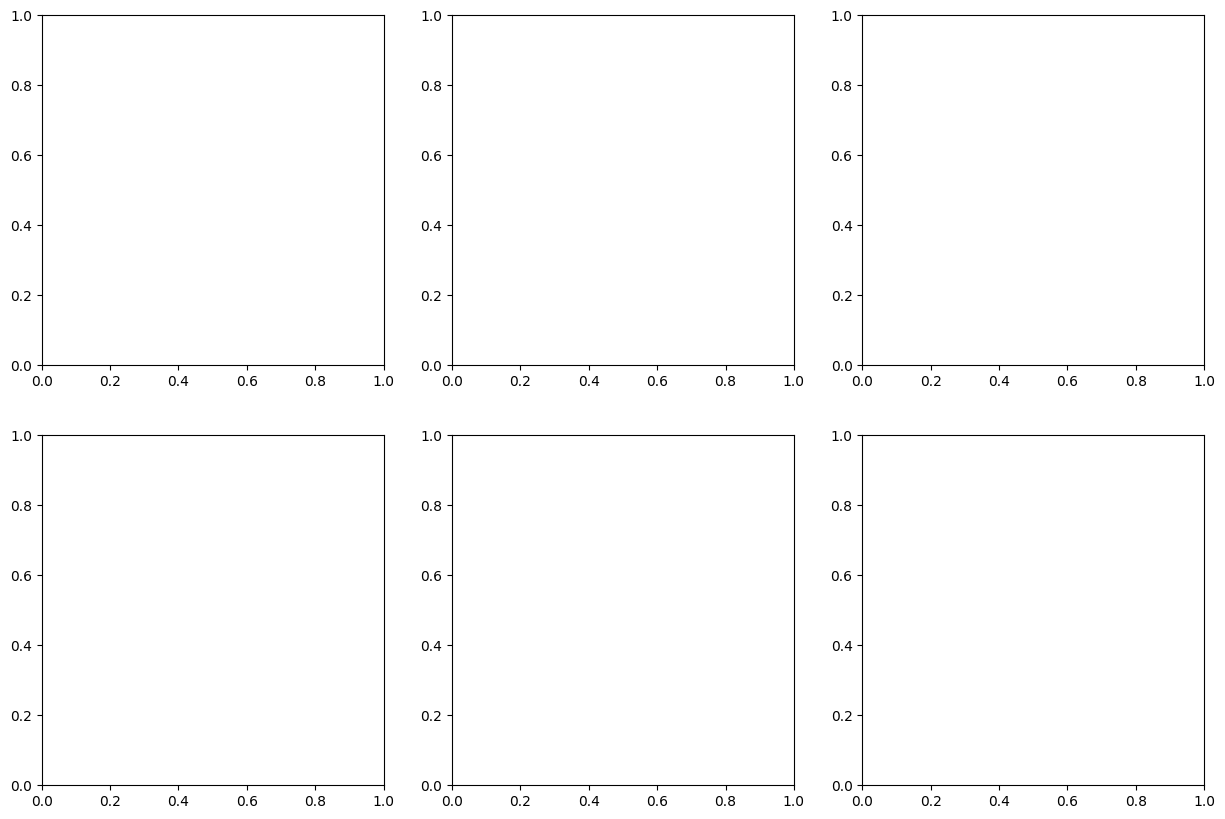

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot validation metrics across folds
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Colors for each fold
colors = plt.cm.tab10(np.linspace(0, 1, NUM_FOLDS))

# Plot 1: Training and Validation Loss
ax = axes[0, 0]
for i, (train_loss, val_loss) in enumerate(zip(fold_results['train_losses'], fold_results['val_losses'])):
    epochs_range = range(1, len(train_loss) + 1)
    ax.plot(epochs_range, train_loss, linestyle='--', color=colors[i], alpha=0.5, label=f'Fold {i+1} Train')
    ax.plot(epochs_range, val_loss, linestyle='-', color=colors[i], label=f'Fold {i+1} Val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training & Validation Loss')
ax.legend(fontsize=7, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 2: Token-level Accuracy
ax = axes[0, 1]
for i, token_accs in enumerate(fold_results['val_token_acc']):
    epochs_range = range(1, len(token_accs) + 1)
    ax.plot(epochs_range, token_accs, color=colors[i], marker='o', markersize=3, label=f'Fold {i+1}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Token Accuracy')
ax.set_title('Validation Token-level Accuracy')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Sequence-level Accuracy
ax = axes[0, 2]
for i, seq_accs in enumerate(fold_results['val_seq_acc']):
    epochs_range = range(1, len(seq_accs) + 1)
    ax.plot(epochs_range, seq_accs, color=colors[i], marker='s', markersize=3, label=f'Fold {i+1}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Sequence Accuracy')
ax.set_title('Validation Sequence-level Accuracy')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 4: MCC
ax = axes[1, 0]
for i, mccs in enumerate(fold_results['val_mcc']):
    epochs_range = range(1, len(mccs) + 1)
    ax.plot(epochs_range, mccs, color=colors[i], marker='^', markersize=3, label=f'Fold {i+1}')
ax.set_xlabel('Epoch')
ax.set_ylabel('MCC')
ax.set_title('Validation Matthews Correlation Coefficient')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 5: Precision
ax = axes[1, 1]
for i, precs in enumerate(fold_results['val_precision']):
    epochs_range = range(1, len(precs) + 1)
    ax.plot(epochs_range, precs, color=colors[i], marker='d', markersize=3, label=f'Fold {i+1}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
ax.set_title('Validation Precision (weighted)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Recall
ax = axes[1, 2]
for i, recs in enumerate(fold_results['val_recall']):
    epochs_range = range(1, len(recs) + 1)
    ax.plot(epochs_range, recs, color=colors[i], marker='v', markersize=3, label=f'Fold {i+1}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')
ax.set_title('Validation Recall (weighted)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.suptitle('K-Fold Cross Validation Metrics (T5 LSTM-CNN)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, '6state_t5_lstm_cnn_metrics_plot.png'), dpi=150)
plt.show()

# Bar plot: Mean metrics with min/max error bars from all folds
fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = ['Token Acc', 'Seq Acc', 'MCC', 'Precision', 'Recall']
x = np.arange(len(metrics_names))
width = 0.5

# Get all fold metrics
all_fold_metrics = fold_results['best_metrics']

all_values = {
    'token_acc': [m['token_acc'] for m in all_fold_metrics],
    'seq_acc': [m['seq_acc'] for m in all_fold_metrics],
    'mcc': [m['mcc'] for m in all_fold_metrics],
    'precision': [m['precision'] for m in all_fold_metrics],
    'recall': [m['recall'] for m in all_fold_metrics]
}

# Calculate mean values
mean_values = [
    np.mean(all_values['token_acc']),
    np.mean(all_values['seq_acc']),
    np.mean(all_values['mcc']),
    np.mean(all_values['precision']),
    np.mean(all_values['recall'])
]

if len(all_fold_metrics) > 1:
    min_values = [
        min(all_values['token_acc']),
        min(all_values['seq_acc']),
        min(all_values['mcc']),
        min(all_values['precision']),
        min(all_values['recall'])
    ]

    max_values = [
        max(all_values['token_acc']),
        max(all_values['seq_acc']),
        max(all_values['mcc']),
        max(all_values['precision']),
        max(all_values['recall'])
    ]

    # Calculate asymmetric error bars (from mean to min/max)
    yerr_lower = [max(0, mean - min_val) for mean, min_val in zip(mean_values, min_values)]
    yerr_upper = [max(0, max_val - mean) for max_val, mean in zip(max_values, mean_values)]
else:
    yerr_lower = [0] * len(mean_values)
    yerr_upper = [0] * len(mean_values)

# Plot bars with lower zorder so grid lines appear on top
ax.bar(x, mean_values, width, color='steelblue', edgecolor='none', zorder=2)
ax.errorbar(x, mean_values, yerr=[yerr_lower, yerr_upper], fmt='none',
            ecolor='black', capsize=5, capthick=1.5, elinewidth=1.5, zorder=4)

# Minimal styling: remove grid, add white horizontal lines
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

# Add subtle horizontal lines for clarity on bar heights (higher zorder to overlap bars)
yticks = np.arange(0, 1.1, 0.2)
for y_tick in yticks:
    ax.axhline(y=y_tick, color='lightgray', linewidth=0.8, zorder=3)

ax.set_ylabel('Score')
ax.set_title(f'Mean Validation Metrics Across {NUM_FOLDS} Folds (Error bars: min/max)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim(0, 1.05)
ax.set_yticks(yticks)

# Add value labels on bars
max_yerr = max(yerr_upper) if max(yerr_upper) > 0 else 0.02
for i, val in enumerate(mean_values):
    ax.text(i, val + max_yerr + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, '6state_t5_lstm_cnn_best_metrics_bar.png'), dpi=150)
plt.show()

print(f"\nPlots saved to {TRAIN_VAL_LOSSES_DATA_SAVE_PATH}")
print(f"Bar plot shows mean metrics across {NUM_FOLDS} folds with min/max error bars")

In [11]:
print(f"\nBest model saved at: {MODEL_SAVE_PATH}")
print(f"Selected fold: {best_fold_num} (by MCC)")
print(f"MCC: {best_fold_mcc:.4f}")
print(f"Validation loss: {best_fold_loss:.4f}")


Best model saved at: /home/jonas/Documents/Projects/sp-prediction/models/6state_t5_lstm_cnn/6state_t5_lstm_cnn.pt
Selected fold: 3 (by MCC)
MCC: 0.8963
Validation loss: 5.2940


In [12]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score, precision_score, recall_score

# Load best model
encoder_eval = T5EncoderModel.from_pretrained(MODEL_NAME, torch_dtype=torch.float16)
encoder_eval.to(DEVICE)
model = SPCNNClassifier(encoder_eval, NUM_CLASSES).to(DEVICE)

model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
print(f"\nModel loaded from {MODEL_SAVE_PATH}")

model.eval()
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Compute loss using CRF
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += loss.item()

        # Decode predictions using CRF
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)

        # Collect valid tokens (skip -100 labels which are [CLS], [SEP], [PAD])
        for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
            for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                if true.item() != -100 and is_valid.item() == 1:
                    all_preds.append(pred)
                    all_labels.append(true.item())

# Calculate metrics
print("\n" + "="*60)
print("Test Set Results")
print("="*60)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

f1_weighted = f1_score(all_labels, all_preds, average='weighted')
f1_macro = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
mcc = matthews_corrcoef(all_labels, all_preds)
token_acc = accuracy_score(all_labels, all_preds)
seq_acc = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
avg_loss = test_loss / len(test_loader)

print(f"\nMetrics Summary:")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Token-level Accuracy: {token_acc:.4f}")
print(f"Sequence Level Accuracy: {seq_acc:.4f}")
print(f"Average test loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
cm_relative = cm.astype("float") / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=list(label_map.keys()))
disp.plot(cmap="OrRd", xticks_rotation=45)
plt.title(f"Confusion Matrix - Best Model (Fold {best_fold_num})")
plt.tight_layout()
plt.show()


`torch_dtype` is deprecated! Use `dtype` instead!


TypeError: unsupported operand type(s) for %: 'T5EncoderModel' and 'int'

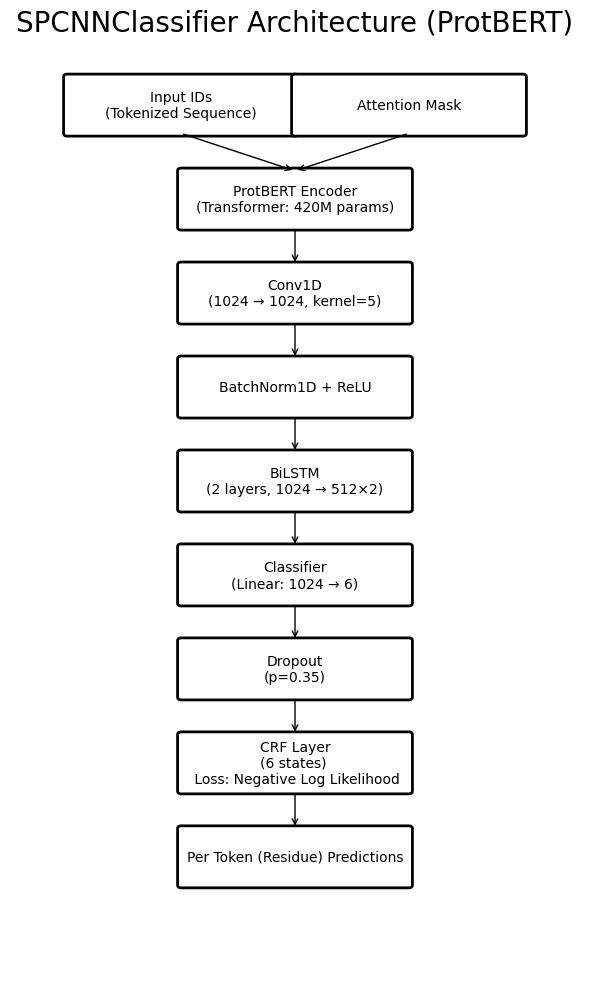

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def draw_vertical_model():
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.axis('off')

    # Define blocks with (x, y)
    blocks = [
        ("Input IDs\n(Tokenized Sequence)", 0.5, 9.0),
        ("Attention Mask", 2.5, 9.0),
        ("T5 Encoder\n(Transformer)", 1.5, 8.0),
        ("Conv1D\n(1024 → 1024, kernel=5)", 1.5, 7.0),
        ("BatchNorm1D + ReLU", 1.5, 6.0),
        ("BiLSTM\n(2 layers, 1024 → 512×2)", 1.5, 5.0),
        ("Classifier\n(Linear: 1024 → 6)", 1.5, 4.0),
        ("Dropout\n(p=0.35)", 1.5, 3.0),
        ("CRF Layer\n(6 states) \n Loss: Negative Log Likelihood", 1.5, 2.0),
        ("Per Token (Residue) Predictions", 1.5, 1.0)
    ]

    box_width = 2.0
    box_height = 0.6

    # Draw blocks
    for label, x, y in blocks:
        rect = mpatches.FancyBboxPatch((x, y), box_width, box_height, boxstyle="round,pad=0.03",
                                       edgecolor='black', facecolor='white', linewidth=2)
        ax.add_patch(rect)
        ax.text(x + box_width / 2, y + box_height / 2, label, ha='center', va='center', fontsize=10)

    # Draw arrows
    for i in range(2, len(blocks) - 1):  # skip input IDs and mask arrows
        x1 = blocks[i][1] + box_width / 2
        y1 = blocks[i][2]
        y2 = blocks[i+1][2] + box_height
        ax.annotate('', xy=(x1, y2), xytext=(x1, y1),
                    arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Draw arrows from inputs
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(0.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(2.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

    plt.title("SPCNNClassifier Architecture (ProtBERT)", fontsize=20)
    plt.ylim(0, 10)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()

draw_vertical_model()